In [1]:
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [3]:
feedline_resonator_gap = 13 
n_gridline = 20
JJtype = "mh" # mh or dl (manhattan or dolan)
Bandage = False
DCLine = True # Add DC line next to squids
Entangle = True # Connect two transmons
SimulationDesign = False # Make inverted design for HFSS simulation (This takes a long time...)
QiskitDesign = True

outname = "waferdesign_2D_" + JJtype
if Bandage:
    outname += "bd"
if DCLine:
    outname += "_dcline"
if Entangle:
    outname += "_entangle"    


config = load_config( f"config/common.yaml" )
# グローバル変数として定義
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


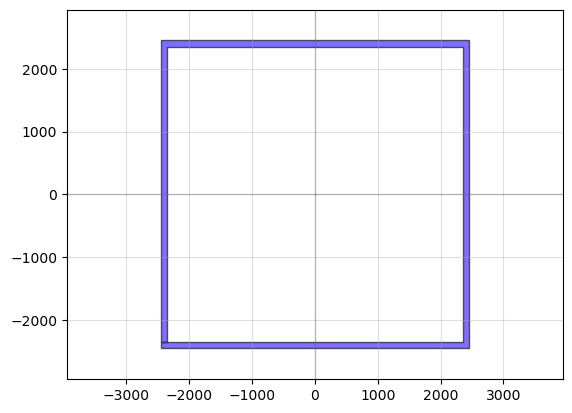

In [5]:
chipdesign = Device('chipdesign')

FM=Device('frame')
rectangle = pg.rectangle((Frame_size_width, Frame_size_height), Frame_layer)
FM.add_ref( pg.invert(rectangle, border = Frame_width, precision = 1e-6, layer = Frame_layer) )
FM.center = (0, 0)

chipdesign.add_ref(FM)
# Quickplot the imported design
qp(chipdesign)

# Launch pad

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


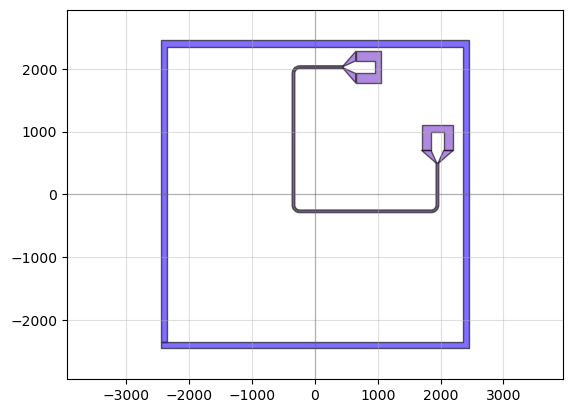

In [6]:
FL = device_FeedLine()
chipdesign.add_ref(FL)
qp(chipdesign)


# Corner points

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


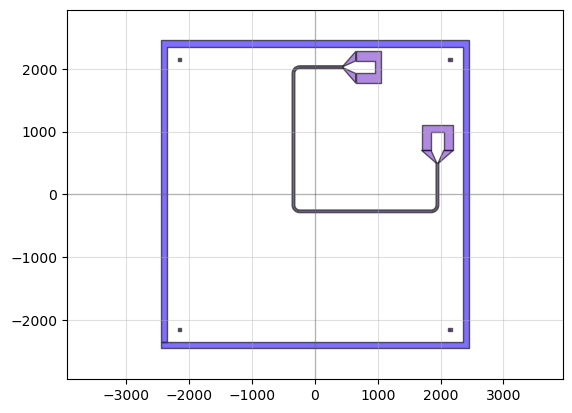

In [7]:
CP = device_CornerPoints()
chipdesign.add_ref(CP)
qp(chipdesign)

# Test Areas

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


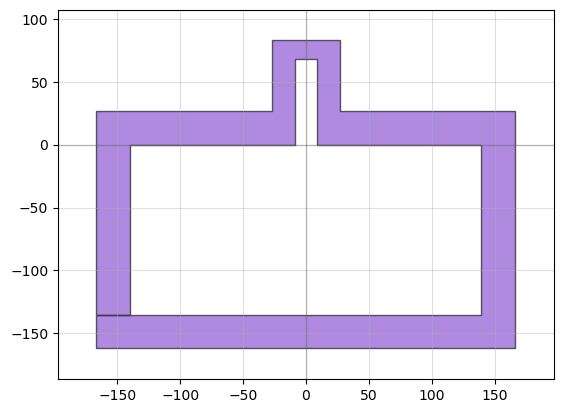

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


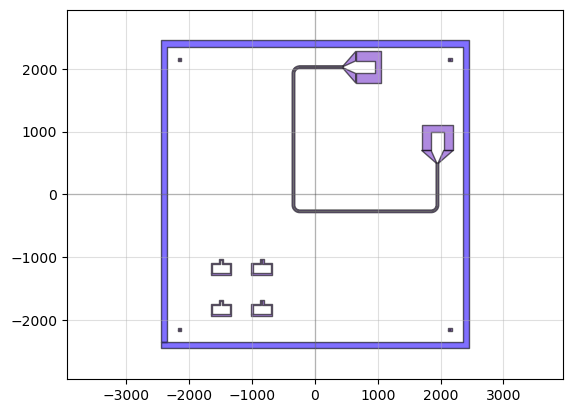

In [8]:
TA = device_TestAreas(DCLine = DCLine)
chipdesign.add_ref(TA)
qp(chipdesign)

# Resonator

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)


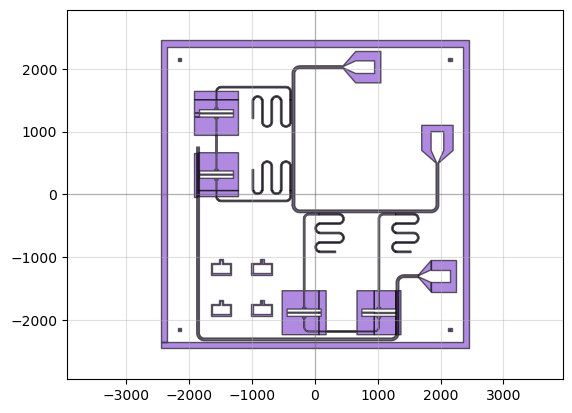

In [9]:
R1_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R1_tmp.movex(1315)
R1_tmp.ymax = FL.ymin - feedline_resonator_gap
R1 = pg.copy_layer(R1_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R1)

R2_tmp = device_Resonator(resonator_straight1 = 240, resonator_straight2 = 290, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R2_tmp.movex(145)
R2_tmp.ymax = FL.ymin - feedline_resonator_gap
R2 = pg.copy_layer(R2_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R2)

if Entangle:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = True, entangle = Entangle)
else:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = False, entangle = Entangle)
R3_tmp.movey(408)
R3_tmp.xmax = FL.xmin - feedline_resonator_gap
R3 = pg.copy_layer(R3_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R3)

R4_tmp = device_Resonator(resonator_straight1 = 275, resonator_straight2 = 325, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, entangle = Entangle)
R4_tmp.movey(1383)
R4_tmp.xmax = FL.xmin - feedline_resonator_gap
R4 = pg.copy_layer(R4_tmp, Resonator_layer, Resonator_layer)
chipdesign.add_ref(R4)

if Entangle:
    # Line_1to2 = Device("Line1to2")
    # Line_3to4 = Device("Line3to4")

    X = CrossSection()
    line_width = 10
    line_gap_width = 6
    X.add(width= line_width, offset = 0, layer = 1)
    X.add(width= line_gap_width, offset = 0.5*(line_width + line_gap_width), layer = 4)
    X.add(width= line_gap_width, offset = -0.5*(line_width + line_gap_width), layer = 4)

    line_1to2 = pr.route_smooth(
        port1 = R1_tmp.references[0].ports['entangle'],
        port2 = R2_tmp.references[0].ports['entangle'],
        width = X,
        radius = 75,
        path_type = 'U',
        length1 = 120 + 75,
        smooth_options=  {'corner_fun': pp.arc}
        )
    
    line_3to4 = pr.route_smooth(
        port1 = R3_tmp.references[0].ports['entangle'],
        port2 = R4_tmp.references[0].ports['entangle'],
        width = X,
        path_type = 'straight')    

    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_1to2, 1, 4), 'not', layer = 4)
    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_3to4, 1, 4), 'not', layer = 4)
    chipdesign.add_ref( pg.copy_layer(line_1to2, 4, 4) )
    chipdesign.add_ref( pg.copy_layer(line_3to4, 4, 4) )


if DCLine:
    DC_tmp = device_DCLine()
    DC = pg.copy_layer(DC_tmp, 4, 4)
    DC_subtract = pg.copy_layer(DC_tmp, 1, 1)
    chipdesign = pg.boolean(chipdesign, DC_subtract, 'not', layer = 4)
    chipdesign.add_ref(DC)

chipdesign.write_gds('output/dcline.gds')
qp(chipdesign)

## Make inverted design for simulation

In [10]:
if SimulationDesign:
    # Produce inverted version for simulation
    chipdesign_inverted = Device('chipdesign_inverted')
    chipdesign_inverted_FL = Device('chipdesign_inverted_FL')
    chipdesign_inverted_FL_DoubleRes = Device('chipdesign_inverted_FL_DoubleRes')
    chipdesign_inverted.add_ref(FL)
    chipdesign_inverted_FL.add_ref(FL)
    chipdesign_inverted_FL_DoubleRes.add_ref(FL)
    chipdesign_inverted_FL_DoubleRes.add_ref(R1_tmp)
    chipdesign_inverted_FL_DoubleRes.add_ref(R4_tmp)
    chipdesign_inverted.add_ref(R1_tmp)
    chipdesign_inverted.add_ref(R2_tmp)
    chipdesign_inverted.add_ref(R3_tmp)
    chipdesign_inverted.add_ref(R4_tmp)
    # chipdesign_inverted.add_ref(CP)
    # chipdesign_inverted.add_ref(TA)
    if DCLine:
        chipdesign_inverted.add_ref(DC_tmp)
    if Entangle:
        chipdesign_inverted.add_ref(line_1to2)
        chipdesign_inverted.add_ref(line_3to4)

    rectangle = pg.bbox([(-2400, -2400),(2400, 2400)], 0)
    trace_DoubleRes = pg.copy_layer(chipdesign_inverted_FL_DoubleRes, 1, Resonator_layer)
    trace = pg.copy_layer(chipdesign_inverted, 1, Resonator_layer)
    chipdesign_inverted = pg.boolean(rectangle, chipdesign_inverted, operation = 'not', layer = Resonator_layer)
    chipdesign_inverted_FL = pg.boolean(rectangle, chipdesign_inverted_FL, operation = 'not', layer = Resonator_layer)
    chipdesign_inverted_FL_DoubleRes = pg.boolean(rectangle, chipdesign_inverted_FL_DoubleRes, operation = 'not', layer = Resonator_layer)

    chipdesign_inverted_FL_DoubleRes.add_ref(trace_DoubleRes)
    chipdesign_inverted.add_ref(trace)

    qp(chipdesign_inverted)
    qp(chipdesign_inverted_FL)
    qp(chipdesign_inverted_FL_DoubleRes)

    chipdesign_inverted.write_gds('output/chipdesign_simulation.gds')
    chipdesign_inverted_FL.write_gds('output/chipdesign_onlyFL_simulation.gds')
    chipdesign_inverted_FL_DoubleRes.write_gds('output/chipdesign_onlyFL_DoubleRes_simulation.gds')

## Make inverted design for Qiskit-metal

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)
Port (name Junction_up, midpoint [ 0. 91.], width 10, orientation 270)
Port (name Junction_down, midpoint [ 0. 75.], width 10, orientation 90)


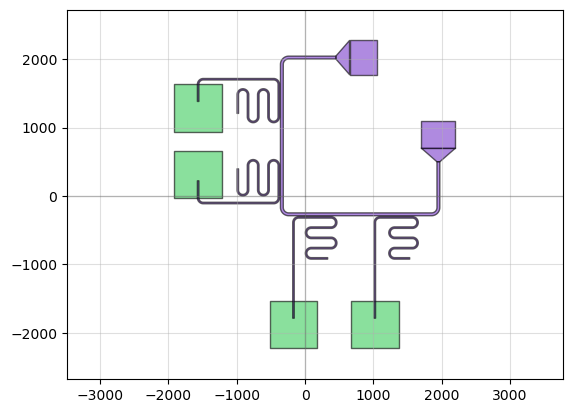

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


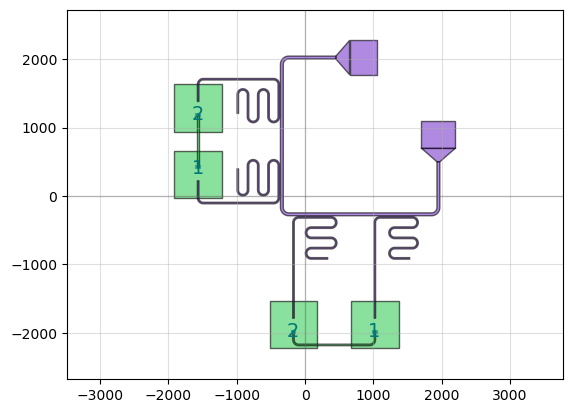

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


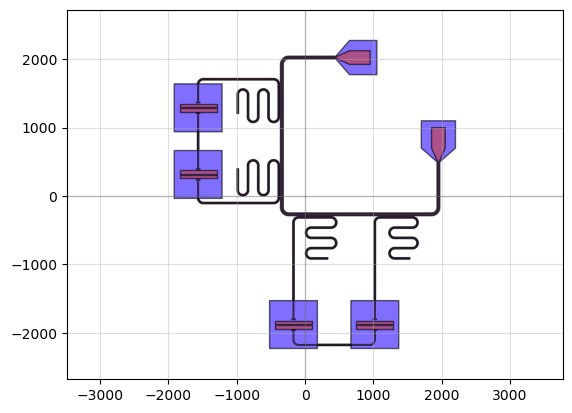

Port (name out, midpoint [ 1020. -1788.], width 10, orientation 90)
Port (name entangle, midpoint [ 1020. -1984.], width 10, orientation 270)
Port (name Junction_up, midpoint [ 1020. -1889.], width 10, orientation 90)
Port (name Junction_down, midpoint [ 1020. -1873.], width 10, orientation 270)
Port (name out, midpoint [ 1020. -1788.], width 10, orientation 270)
Port (name out, midpoint [ -170. -1788.], width 10, orientation 90)
Port (name entangle, midpoint [ -170. -1984.], width 10, orientation 270)
Port (name Junction_up, midpoint [ -170. -1889.], width 10, orientation 90)
Port (name Junction_down, midpoint [ -170. -1873.], width 10, orientation 270)
Port (name out, midpoint [ -170. -1788.], width 10, orientation 270)
Port (name out, midpoint [-1565.   222.], width 10, orientation 270.0)
Port (name entangle, midpoint [-1565.   418.], width 10, orientation 90.0)
Port (name Junction_up, midpoint [-1565.   323.], width 10, orientation 270.0)
Port (name Junction_down, midpoint [-1565. 

In [11]:
if QiskitDesign:
    # 1. Make device for cpw and pocket
    chipdesign_qiskit = Device('chipdesign_qiskit')
    chipdesign_qiskit_pocket = Device('chipdesign_qiskit_pocket')

    # 2. Make pocket designs 
    #    Basically doing the same thing with the pocket option
    #    We don't want to redo the same operation, so we should make a function, or produce pockets at the same time
    FL_qiskit_pocket = device_FeedLine(pocket = True)
    chipdesign_qiskit_pocket.add_ref(FL_qiskit_pocket)

    R1_pocket = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle, pocket = True)
    R1_pocket.movex(1315)
    R1_pocket.ymax = FL_qiskit_pocket.ymin - feedline_resonator_gap
    chipdesign_qiskit_pocket.add_ref(R1_pocket)

    R2_pocket = device_Resonator(resonator_straight1 = 240, resonator_straight2 = 290, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle, pocket = True)
    R2_pocket.movex(145)
    R2_pocket.ymax = FL_qiskit_pocket.ymin - feedline_resonator_gap
    chipdesign_qiskit_pocket.add_ref(R2_pocket)

    if Entangle:
        R3_pocket = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = True, entangle = Entangle, pocket = True)
    else:
        R3_pocket = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = False, entangle = Entangle, pocket = True)
    R3_pocket.movey(408)
    R3_pocket.xmax = FL_qiskit_pocket.xmin - feedline_resonator_gap
    chipdesign_qiskit_pocket.add_ref(R3_pocket)

    R4_pocket = device_Resonator(resonator_straight1 = 275, resonator_straight2 = 325, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, entangle = Entangle, pocket = True)
    R4_pocket.movey(1383)
    R4_pocket.xmax = FL_qiskit_pocket.xmin - feedline_resonator_gap
    chipdesign_qiskit_pocket.add_ref(R4_pocket)

    qp(chipdesign_qiskit_pocket)

    if Entangle:

        line_1to2_pocket = pr.route_smooth(
            port1 = R1_pocket.references[0].ports['entangle'],
            port2 = R2_pocket.references[0].ports['entangle'],
            width = line_width + 2*line_gap_width,
            radius = 75,
            path_type = 'U',
            length1 = 120 + 75,
            smooth_options=  {'corner_fun': pp.arc}
            )

        line_3to4_pocket = pr.route_smooth(
            port1 = R3_pocket.references[0].ports['entangle'],
            port2 = R4_pocket.references[0].ports['entangle'],
            width = line_width + 2*line_gap_width,
            path_type = 'straight')    


        #chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_1to2, 1, 4), 'not', layer = 4)
        #chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_3to4, 1, 4), 'not', layer = 4)
        chipdesign_qiskit_pocket.add_ref( line_1to2_pocket )
        chipdesign_qiskit_pocket.add_ref( line_3to4_pocket )        
    
    qp(chipdesign_qiskit_pocket)

    # 3. 
    chipdesign_qiskit.add_ref(FL)    
    chipdesign_qiskit.add_ref(R1)
    chipdesign_qiskit.add_ref(R2)
    chipdesign_qiskit.add_ref(R3)
    chipdesign_qiskit.add_ref(R4) 
    if Entangle:    
        chipdesign_qiskit = pg.boolean(chipdesign_qiskit, pg.copy_layer(line_1to2, 1, 4), 'not', layer = 4)
        chipdesign_qiskit = pg.boolean(chipdesign_qiskit, pg.copy_layer(line_3to4, 1, 4), 'not', layer = 4)
        chipdesign_qiskit.add_ref( pg.copy_layer(line_1to2, 4, 4) )
        chipdesign_qiskit.add_ref( pg.copy_layer(line_3to4, 4, 4) )

    chipdesign_qiskit = pg.boolean(chipdesign_qiskit_pocket, chipdesign_qiskit, operation = 'not')
    chipdesign_qiskit = pg.union( chipdesign_qiskit, layer = 2 )  
    chipdesign_qiskit_pocket = pg.union( chipdesign_qiskit_pocket, layer = 1 )
    chipdesign_qiskit.add_ref(chipdesign_qiskit_pocket)
    chipdesign_qiskit.flatten()     
    qp(chipdesign_qiskit)
    chipdesign_qiskit.write_gds('output/qiskit-metal/chipdesign.gds')   

    # Dump port data
    port_data = {}
    i = 0
    for port in FL_qiskit_pocket.get_ports():
        if port.name == "LaunchPad":
            start, end = phidl_port_to_metal_pin(port)
            port_data[port.name + str(i)] = {
                "start" : start,
                "end" : end,
                "width" : float(port.width),
                "gap" : float(LaunchPad_pad_gap_length - LaunchPad_pad_length),
            }
            i+=1
    junction_data = {}
    junction_list = [R1_tmp, R2_tmp, R3_tmp, R4_tmp]
    for i, component in enumerate(junction_list):
        key = f"Junction{i}"
        junction_data[key] = {}
        for port in component.get_ports():  
            print(port) 
            if port.name == "Junction_up":
                junction_data[key]["start"] = [float(port.midpoint[0]), float(port.midpoint[1])]
            elif port.name == "Junction_down":
                junction_data[key]["end"] = [float(port.midpoint[0]), float(port.midpoint[1])]           
                junction_data[key]["width"] = float(port.width)
    print(junction_data)
    with open('output/qiskit-metal/chipdesign.yaml', 'w') as f:
        yaml.dump(port_data, f) 
        yaml.dump(junction_data, f)        

# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


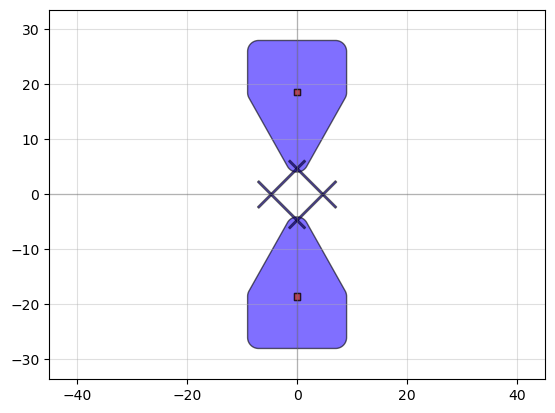

In [12]:
JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False)
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = False, bandage = False)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add test boxes for EB

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


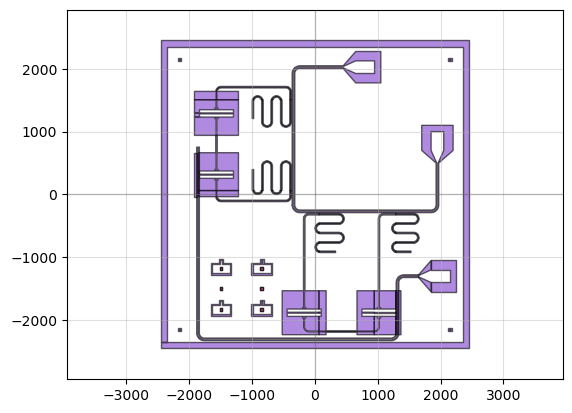

In [13]:
BX = device_TestBoxes(DCLine = DCLine)
chipdesign.add_ref(BX)
qp(chipdesign)

# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


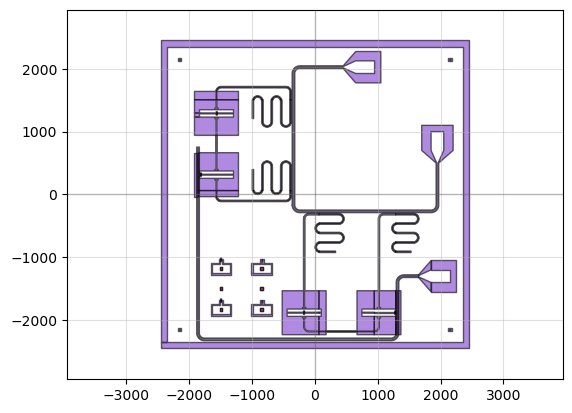

'output/chipdesign.gds'

In [14]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ_trans = device_JJ(width = width, JJtype = JJtype, squid = False, bandage = Bandage)
    JJ_squid = device_JJ(width = width, JJtype = JJtype, squid = True , bandage = Bandage)
    EBLine = device_EBLine()

    # SQUID
    chip.add_ref(JJ_squid).movex(1280).movey(-1880)
    # transmon
    chip.add_ref(JJ_trans).movex(-172).movey(-1880)
    # SQUID
    chip.add_ref(JJ_squid).movex(-1815).movey(315)    
    # transmon
    chip.add_ref(JJ_trans).movex(-1560).movey(1290)

    # transmon (test)
    if DCLine:
        chip.add_ref(JJ_trans).movex(-1493).movey(-1689)
        chip.add_ref(JJ_trans).movex(-1493).movey(-1038)
        chip.add_ref(EBLine).movex(-843).movey(-1689)
        chip.add_ref(EBLine).movex(-843).movey(-1038)
    else:
        chip.add_ref(JJ_trans).movex(-1743).movey(-1739)
        chip.add_ref(JJ_trans).movex(-1743).movey(-1088)
        chip.add_ref(EBLine).movex(-1093).movey(-1739)
        chip.add_ref(EBLine).movex(-1093).movey(-1088)    

    return chip

chip = custom_chip(width = 0.135, height = None)
qp(chip)
chip.write_gds('output/chipdesign')

# Place chip designs

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


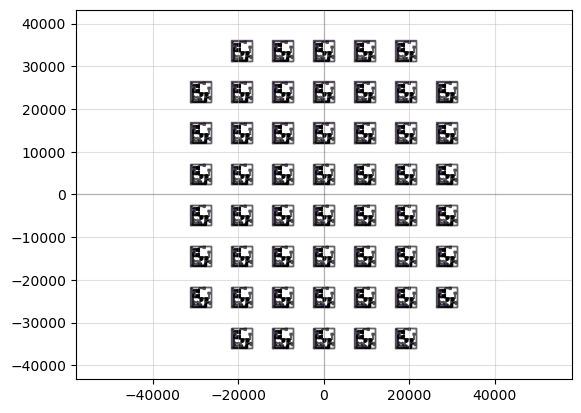

In [15]:


D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  Grid_width},
    param_y = {'height' : Grid_height},
    spacing = (Grid_gap_x * Frame_size_width, Grid_gap_y * Frame_size_height),
    label_layer = None
    )
D.center = (0,0)

## Remove corners
for iref, ref in enumerate(D.references[:]):
    if iref == 0 or iref == len(Grid_width)-1 or iref == len(Grid_width) * (len(Grid_height)-1) or iref == len(Grid_width) * len(Grid_height) - 1:
        D.remove(ref)

wafer.add_ref(D)
qp(D)


# Add EB markers

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


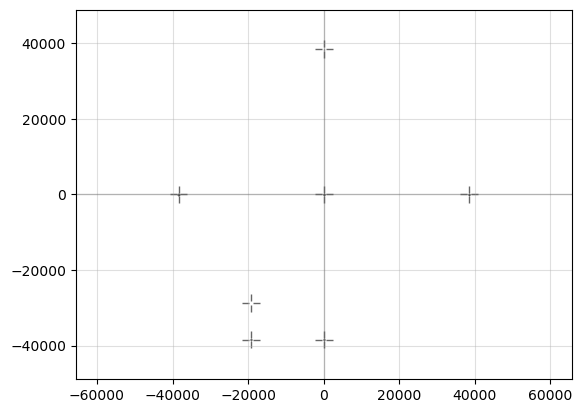

DeviceReference (parent Device "EBmarkers", ports [], origin (0, 0), rotation 0, x_reflection False)

In [16]:
EBmarkers = device_EBmarkers(marker_pos = EBMarker_pos, layer = EBMarker_layer)
qp(EBmarkers)
wafer.add_ref(EBmarkers)


# Add grid lines

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


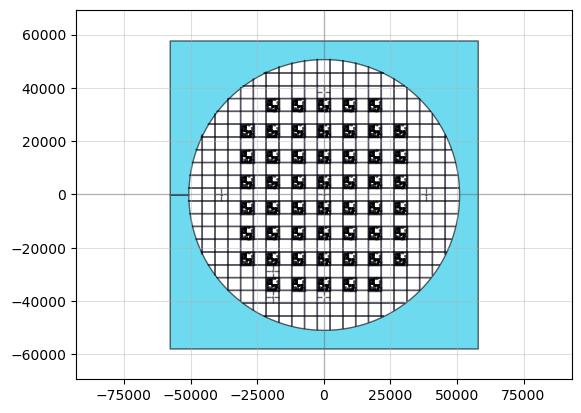

In [17]:
grid = device_Grid(inch = 4, n_gridline = n_gridline)
wafer.add_ref( grid )

qp(wafer)


In [18]:
wafer.write_gds('output/' + outname)

'output/waferdesign_2D_mh_dcline_entangle.gds'